In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os

from sklearn.preprocessing import LabelEncoder
from functions import equal, find_nearest, impute_immediate_mean, impute_mean_day, daylight_savings_shift, clean_weather

## Energy Dataset

In [2]:
energy = pd.read_csv('../data/energy_dataset.csv')

# Chop of nanoseconds, and convert to datetime, reset index
energy.time = pd.to_datetime(energy.time.apply(lambda x: x[:-6]))
energy.set_index('time', inplace=True)

# Get rid of columns that do not contain any information
energy = energy.drop(columns = energy.loc[:,energy.nunique()<=1].columns)

# Create start stop variable for indices
start = dt.datetime(2015, 1, 1)
stop = dt.datetime(2018, 12, 31, 23)

# Create continuous list of indices by hour
yr15_18 = pd.DataFrame(index = pd.date_range(start, stop, freq='H' ))

# join existing data on the complete list of indices
energy = energy.join(yr15_18,how='right')

# Loop through each column and impute missing values
for col in energy.columns:
    
    # Get the indices of missing values in this column
    indices = energy.loc[energy[col].isna()].index
    
    # For each missing value, impute the mean of closest known values
    for i in indices:
        energy.loc[i, col] = impute_immediate_mean(energy[col], i)
        
# Get indices of duplicates
indices = energy.loc[energy.index.value_counts()>1].index.unique()

# average duplicate values for each column
for col in energy.columns:
    for i in indices:
        energy.loc[i, col] = round(energy.loc[i,col].mean(),1)
        

# Drop duplicates
energy.drop_duplicates(inplace=True)

# Create total generation column summing all generation sources
energy['generation total'] = energy.loc[:,:'generation wind onshore'].sum(axis=1)

# Create diff column (difference between total generation and actual load)
energy['diff'] = energy['generation total'] - energy['total load actual']

columns = ['generation biomass',
           'generation fossil brown coal/lignite',
           'generation fossil hard coal',
           'generation fossil oil',
           'generation hydro run-of-river and poundage',
           'generation hydro water reservoir',
           'generation nuclear',
           'generation other',
           'generation other renewable',
           'generation solar',
           'generation waste',
           'generation wind onshore',]
for col in columns:
    flag_indices = energy.loc[energy['diff']<-15000].index
    for i in flag_indices:
        energy.loc[i, col] = impute_immediate_mean(energy[col], i)

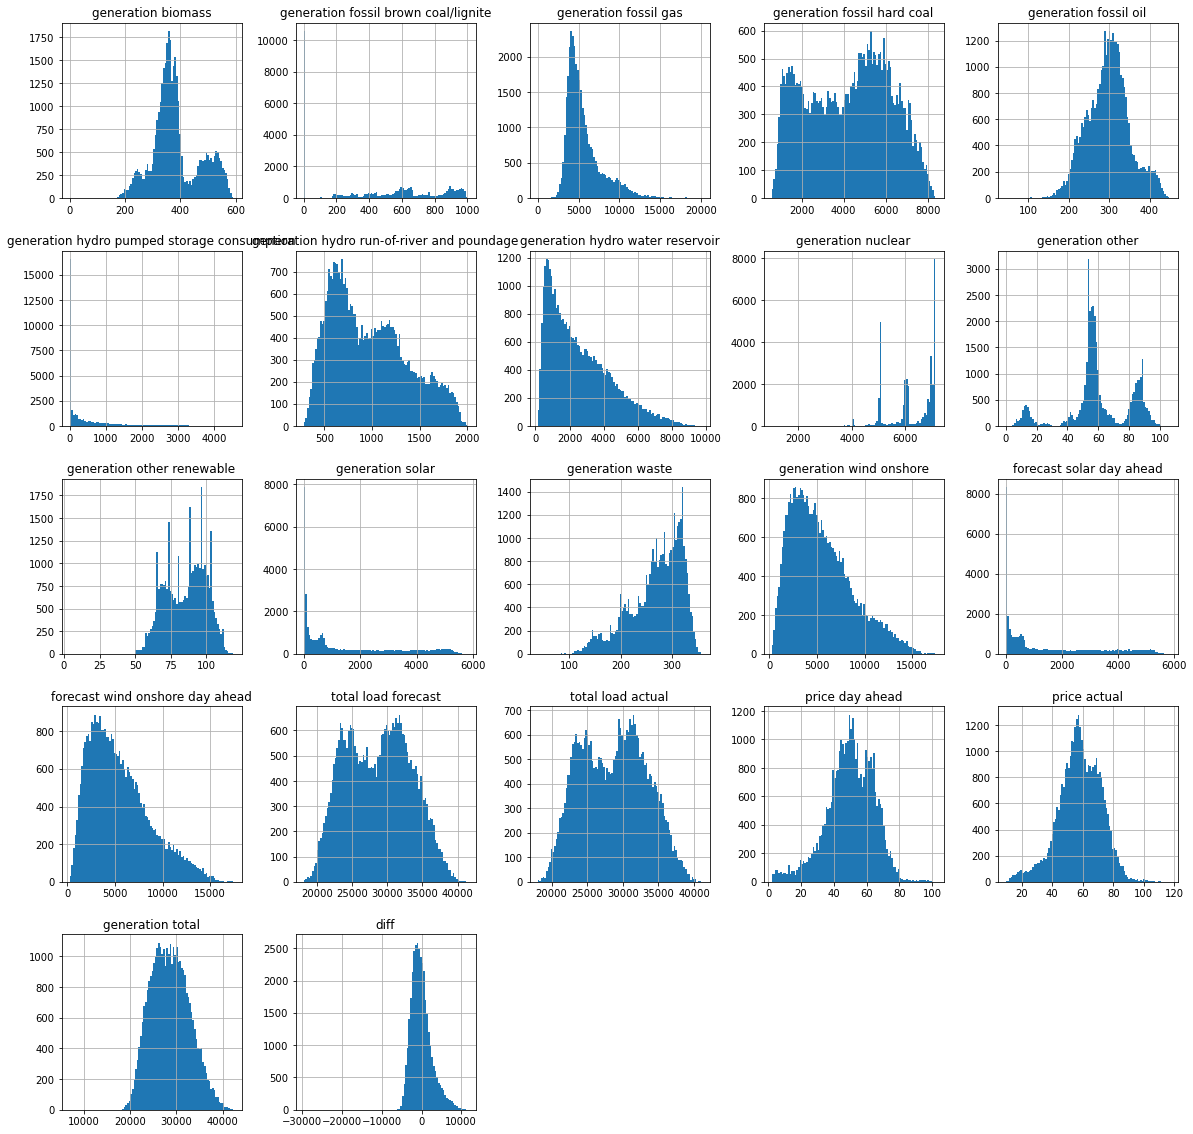

In [89]:
energy.hist(figsize=(20,20), bins=100);

## Weather Data

In [593]:
cities = ['madrid', 'seville', 'barcelona', 'bilbao', 'valencia']
dfs = []
for city in cities:
    # Read in city dataframe
    city_df = pd.read_csv(f'../data/weather/{city}.csv', index_col=0)

    # Clean the madrid data
    city_df = clean_weather(city_df)

    # Rename columns
    city_df.columns = city_df.columns + f'_{city}'
    
    dfs.append(city_df)

madrid
seville
barcelona
bilbao
valencia


In [596]:
# Create daterange
index = pd.date_range(start=dt.datetime(2015,1,1),
                      end = dt.datetime(2021,12,31),
                      freq='H')
range_ = pd.DataFrame(index=index)

# Join to date range in weather data
weather = range_.join([dfs[0], dfs[1], dfs[2], dfs[3], dfs[4]])

# Drop unnecessary columns
weather.drop(columns=['index_madrid', 'index_seville', 'index_barcelona',
                      'index_bilbao', 'index_valencia'],
             inplace=True)

# Get list of categoricals and continuous variables
categorical = weather.select_dtypes(include='object').columns
continuous = weather.select_dtypes(exclude='object').columns

# Impute the mean day for continuous variables with 12 or more missing
for col in continuous:
    impute_mean_day(weather, col, 12)

# Interpolate remaining continuous Nans
weather.loc[:, continuous] = weather.loc[:, continuous].interpolate(limit=12)

# Back fill categorical nans
weather.loc[:,categorical] = weather[categorical].fillna(value='unknown')

# Back fill remaining nans (first five rows of dataset)
weather = weather.fillna(method='bfill')

# Drop duplicates in the index
weather.reset_index(inplace=True)
weather.drop_duplicates(subset='index', inplace=True)
weather.set_index('index', inplace=True)

## Weather Data

In [3]:
weather = pd.read_csv('../data/weather_features.csv')

# Drop duplicates
weather.drop_duplicates(inplace=True)

# Cut off nanoseconds and create datetime column
weather.dt_iso = pd.to_datetime(weather.dt_iso.apply(lambda x: x[:-6]))

# Drop columns since weather description provides most granular level of information
weather.drop(columns=['weather_id', 'weather_main', 'weather_icon', 'temp_min', 'temp_max'], inplace=True)

# Create weather by city df
weather_by_city = pd.DataFrame()

for city in weather.city_name.unique():
    
    # Copy data by city
    city_df = weather.loc[weather.city_name == city].copy()

    # Get the combined weather descriptions for timestamps with multiple descriptions
    combined = city_df.groupby('dt_iso')['weather_description'].transform(lambda x : '/'.join(x))

    # assign new to combined descriptions
    city_df['description'] = combined

    # Drop original weather description column
    city_df.drop(columns=['city_name','weather_description'], inplace=True)

    # Drop duplicates
    city_df.drop_duplicates(inplace=True)
    
    # Set index
    city_df = city_df.set_index('dt_iso')
    
    # Rename cols
    city_df.columns = city_df.columns.map(lambda x: x + f'_{city}')
    
    # Join to the weather_cities df
    weather_by_city = city_df.join(weather_by_city, how='left')

# Replace values in duplicated indices with the max
weather_by_city = weather_by_city.groupby(by=weather_by_city.index).max()

# join existing data on the complete list of indices
weather_by_city = weather_by_city.join(yr15_18,how='right')
weather_by_city

# Impute the immediate mean for all missing values in continuous cols
continuous = weather_by_city.select_dtypes(exclude='object').columns
for col in continuous:
    indices = weather_by_city.loc[weather_by_city[col].isna()].index
    for i in indices:
        weather_by_city.loc[i,col] = impute_immediate_mean(weather_by_city[col], i)

# Impute the previous known col for remaining cols
weather_by_city.fillna(method='bfill', inplace=True)
    
# Get all unique weather descriptions for each city
categorical = weather_by_city.select_dtypes(include='object').columns
descriptions = set()
for col in categorical:
    unique = set(weather_by_city[col].unique())
    descriptions = unique | descriptions
descriptions = list(descriptions)

# Instantiate LabelEncoder and transform cols
encoder = LabelEncoder()
encoder.fit(descriptions)
for col in categorical:
    weather_by_city[col] = encoder.transform(weather_by_city[col])

## Cross Border Transmission Data

In [4]:
# Read in France Border Data
france = pd.DataFrame()
portugal = pd.DataFrame()

for file in os.listdir('../data/cross_border/france'):
    data = pd.read_csv(f'../data/cross_border/france/{file}')
    data.drop_duplicates(subset='Time (CET)', inplace=True)
    france = pd.concat([france, data],axis=0)

# Convert Time to datetime
france['time'] = france['Time (CET)'].apply(lambda x: x[:16])
france['time'] = pd.to_datetime(france['time'])
france = france.set_index('time').drop(columns='Time (CET)')

# Read in Portugal Border Data
for file in os.listdir('../data/cross_border/portugal'):
    data = pd.read_csv(f'../data/cross_border/portugal/{file}')
    data.drop_duplicates(subset='Time (CET)', inplace=True)
    portugal = pd.concat([portugal, data],axis=0)
portugal['time'] = portugal['Time (CET)'].apply(lambda x: x[:16])
portugal['time'] = pd.to_datetime(portugal['time'])
portugal = portugal.set_index('time').drop(columns='Time (CET)')

# Join France and Portugal Data
border = portugal.join(france)
border.fillna(method='ffill', inplace=True)
cols = dict(zip(border.columns,['transmission_ps', 
                                'transmission_sp', 
                                'transmission_fs',
                                'transmission_sf']))

border.rename(columns=cols, inplace=True)

## Generation (2019-2021)

In [5]:
gen = pd.DataFrame()
for file in os.listdir('../data/generation'):
    load = pd.read_csv(f'../data/generation/{file}')
    load.drop_duplicates(subset='MTU', inplace=True)
    gen = pd.concat([gen, load], axis=0)
    
# Get rid of columns that do not contain any information
gen = gen.drop(columns = gen.loc[:,gen.nunique()<=1].columns)

# Convert Time to datetime
gen['time'] = pd.to_datetime(gen.MTU.apply(lambda x: x[:13]))

# Set index to the time col
gen.set_index('time', inplace=True)

# Drop MTU col
gen.drop(columns='MTU', inplace=True)

# Rename cols
gen.columns = gen.columns.map(lambda x: ('generation '+ x[:-26]).lower())
gen.rename(columns={'generation hydro pumped storage ': 'generation hydro pumped storage consumption'},
           inplace=True)

# Impute Immediate Mean for NaNs
for col in gen.columns:
    indices = gen.loc[gen[col].isna()].index
    for i in indices:
        gen.loc[i,col] = impute_immediate_mean(gen[col], i)

## Load Forecast and Actual (2019-2021)

In [6]:
load_forecast = pd.DataFrame()
for file in os.listdir('../data/load'):
    load = pd.read_csv(f'../data/load/{file}')
    load.drop_duplicates(subset='Time (CET)', inplace=True)
    load_forecast = pd.concat([load_forecast, load], axis=0)

# Convert Time to datetime
load_forecast['time'] = pd.to_datetime(load_forecast['Time (CET)'].apply(lambda x: x[:13]))

# Set index to the time col
load_forecast.set_index('time', inplace=True)

# Drop 'Time (CET)' col
load_forecast.drop(columns='Time (CET)', inplace=True)

# Rename cols
load_forecast.rename(columns = {'Day-ahead Total Load Forecast [MW] - BZN|ES':'total load forecast',
                                'Actual Total Load [MW] - BZN|ES':'total load actual'}, 
                     inplace=True)

# Impute Immediate Mean for NaNs
for col in load_forecast.columns:
    indices = load_forecast.loc[load_forecast[col].isna()].index
    for i in indices:
        load_forecast.loc[i,col] = impute_immediate_mean(load_forecast[col], i)

## Wind and Solar Forecast (2019-2021)

In [7]:
ws = pd.DataFrame()
for file in os.listdir('../data/wind_solar_day_ahead'):
    load = pd.read_csv(f'../data/wind_solar_day_ahead/{file}')
    load.drop_duplicates(subset='MTU (CET)', inplace=True)
    ws = pd.concat([ws, load], axis=0)
    
# Convert Time to datetime
ws['time'] = pd.to_datetime(ws['MTU (CET)'].apply(lambda x: x[:13]))

# Set index to the time col
ws.set_index('time', inplace=True)

# Drop 'Time (CET)' col
ws = ws[['Generation - Solar  [MW] Day Ahead/ BZN|ES',
         'Generation - Wind Onshore  [MW] Day Ahead/ BZN|ES']].copy()

# Rename cols
ws.rename(columns = {'Generation - Solar  [MW] Day Ahead/ BZN|ES':'forecast solar day ahead',
                     'Generation - Wind Onshore  [MW] Day Ahead/ BZN|ES':'forecast wind onshore day ahead'}, 
                     inplace=True)

# 2020-05-01 wind forecast is missing, impute average for that day in may
avg_w = ws['forecast wind onshore day ahead'].groupby(by=[ws.index.month, 
                                                          ws.index.day,
                                                          ws.index.hour]).mean().loc[(5,1)]
for i, time in enumerate(ws.loc['2020-05-01'].index):
    ws.loc[time, 'forecast wind onshore day ahead'] = avg_w[i]
    
# Impute the immediate mean for remaining NaNs
for col in ws.columns:
    indices = ws.loc[ws[col].isna()].index
    for i in indices:
        ws.loc[i,col] = impute_immediate_mean(ws[col], i)

## Day Ahead Prices (2019-2021)

In [8]:
# Load and combine all day ahead price data into single dataframe
price_ahead = pd.DataFrame()
for file in os.listdir('../data/day ahead price'):
    load = pd.read_csv(f'../data/day ahead price/{file}')
    load.drop_duplicates(subset='MTU (CET)', inplace=True)
    price_ahead = pd.concat([price_ahead, load], axis=0)
    
# Convert Time to datetime
price_ahead['time'] = price_ahead['MTU (CET)'].apply(lambda x: x[:16])
price_ahead['time'] = pd.to_datetime(price_ahead['time'])

# Drop unused columns and rows
price_ahead.drop(columns=['MTU (CET)', 'BZN|ES'], inplace=True)

# Set index to the time col
price_ahead.set_index('time', inplace=True)

# Drop all data in 2022 since incomplete
price_ahead = price_ahead.loc[:'2021'].copy()

# Rename col
price_ahead.rename(columns={'Day-ahead Price [EUR/MWh]':'price day ahead'}, inplace=True)

# Impute the immediate mean for remaining NaNs
for col in price_ahead.columns:
    indices = price_ahead.loc[price_ahead[col].isna()].index
    for i in indices:
        price_ahead.loc[i,col] = impute_immediate_mean(price_ahead[col], i)

## Generation Forecast Day ahead

In [9]:
# Load and combine all day ahead price data into single dataframe
gen_forecast = pd.DataFrame()
for file in os.listdir('../data/gen_forecast'):
    load = pd.read_csv(f'../data/gen_forecast/{file}')
    load.drop_duplicates(subset='MTU', inplace=True)
    gen_forecast = pd.concat([gen_forecast, load], axis=0)
    
# Convert Time to datetime
gen_forecast['time'] = gen_forecast['MTU'].apply(lambda x: x[:16])
gen_forecast['time'] = pd.to_datetime(gen_forecast['time'])

# Drop unused columns and rows
gen_forecast.drop(columns='MTU', inplace=True)

# Set index to the time col
gen_forecast.set_index('time', inplace=True)


# Rename cols
gen_forecast.rename(columns={'Scheduled Generation [MW] (D) - BZN|ES':'generation_scheduled',
                             'Scheduled Consumption [MW] (D) - BZN|ES':'consumption_scheduled'},
                    inplace=True)

for col in gen_forecast.columns:
    
    # Impute the mean of the nearest known date by hour
    impute_mean_day(gen_forecast, col, 24)
    
    # Fill remaining Nans
    gen_forecast[col].fillna(method='bfill', inplace=True)

## Prices (2019-2021)

In [10]:
# Import
prices_19_21 = pd.read_csv('../data/prices.csv')

# Change column to datetime and set as index
prices_19_21['datetime'] = pd.to_datetime(prices_19_21['datetime'])
prices_19_21.set_index('datetime', inplace=True)

# Drop duplicates and all rows in 2022
prices_19_21 = prices_19_21.groupby(by=prices_19_21.index).max()
prices_19_21 = prices_19_21.loc['2019':'2021'].copy()

## Combine dataframes

In [11]:
# Combine data from years 2015-2018
df_15_18 = energy.join(weather_by_city)

# Combine data from years 2019-2021
df_19_21 = gen.join([load_forecast, ws, price_ahead, prices_19_21])

# Join data from 2015-2021
df_15_21 = gen_forecast.join(border)

# Concatenate data from 15-18 with 19-21 and transmission data
df = pd.concat([df_15_18, df_19_21], axis=0).join(df_15_21)

## Clean df

In [17]:
# Drop 5/20/21 - 5/31/21 since missing price data
drop = pd.date_range(start='2021-05-20 08', end='2021-05-31 23', freq='H')
df.drop(drop, inplace=True)

# Impute remaining missing price data
indices = df.loc[df['price actual'].isna()].index
for i in indices:
    df.loc[i, 'price actual'] = impute_immediate_mean(df['price actual'], i)
    
df['generation total'] = df.loc[:,:'generation wind onshore'].sum(axis=1)
df['diff'] = df['total load actual'] - df['generation total']

## Export Data

In [19]:
# Export to csv
energy.to_csv('../data/energy_clean.csv')
weather_by_city.to_csv('../data/weather_clean.csv')
border.to_csv('../data/transmission_clean.csv')
gen.to_csv('../data/generation_2019-21.csv')
load_forecast.to_csv('../data/load_forecast_2019-21.csv')
ws.to_csv('../data/wind_solar_2019-21.csv')
price_ahead.to_csv('../data/price_ahead_2019-21.csv')
gen_forecast.to_csv('../data/gen_forecast.csv')
df.to_csv('../data/df_clean.csv')